In [ ]:
import pandas as pd
import numpy as np
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
address = "https://raw.githubusercontent.com/Jaeik-Jeong/RLES/main/"

data_price = pd.read_csv(address+'price.csv', index_col=0)
data_train_csv = pd.DataFrame(data_price['Price'][:1000])
data_val_csv   = pd.DataFrame(data_price['Price'][1000:1500])
data_test_csv  = pd.DataFrame(data_price['Price'][1500:2000])

In [ ]:
# Data Preprocessing

Battery_Size = 1 #p.u.

max_price = max(data_price['Price'])

size_train0 = len(data_train_csv)
size_val0   = len(data_val_csv)
size_test0  = len(data_test_csv)

price_train = list(data_train_csv['Price']/max_price)
price_val = list(data_val_csv['Price']/max_price)
price_test = list(data_test_csv['Price']/max_price)

In [ ]:
# Agent

n_layers         = 2
in_size          = 2
hidden_size      = 64
out_size         = 3
T_horizon        = 128
learning_rate    = 0.001
K_epoch          = 3
gamma            = 0.99
lmbda            = 0.95
eps_clip         = 0.1
C_value          = 1
var              = 0.1**2
buffer_limit  = 50000
batch_size    = 32
epsilon       = 0.1

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        o, H, a, r, o_prime, H_prime, done = [], [], [], [], [], [], []

        for transition in mini_batch:
            o.append(transition[0])
            H.append(transition[1])
            a.append(transition[2])
            r.append([transition[3]])
            o_prime.append(transition[4])
            H_prime.append(transition[5])
            done.append([0]) if transition[6] else done.append([1])

        o         = torch.tensor(o,dtype=torch.float)
        H         = (H[0][0].detach(), H[0][1].detach())
        a         = torch.tensor(a)
        r         = torch.tensor(r,dtype=torch.float)
        o_prime   = torch.tensor(o_prime,dtype=torch.float)
        H_prime   = (H_prime[0][0].detach(), H_prime[0][1].detach())
        done      = torch.tensor(done)

        return o, H, a, r, o_prime, H_prime, done

    def size(self):
        return len(self.buffer)

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.fc_in  = nn.Linear(in_size, hidden_size)
        self.rnn   = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, hidden):
        x = F.relu(self.fc_in(x))
        x = x.view(1, -1, hidden_size)
        x, hidden = self.rnn(x, hidden)
        x = self.fc_out(x)
        x = x.view(-1, out_size)
        return x, hidden

    def sample_action(self, x, hidden, epsilon):
        out, hidden = self.forward(x, hidden)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,2), hidden
        else :
            return out.argmax().item(), hidden

In [ ]:
# Environment

E_max   = Battery_Size
P_max   = E_max
tdelta  = 0.5
soc_min = 0.1
soc_max = 0.9
a0 = -1.031; a1 = 35; a2 = 3.685; a3 = 0.2156; a4 = 0.1178; a5 = 0.3201
b0 = 0.1463; b1 = 30.27; b2 = 0.1037; b3 = 0.0584; b4 = 0.1747; b5 = 0.1288
c0 = 0.1063; c1 = 62.49; c2 = 0.0437; d0 = 0.0712; d1 = 61.4; d2 = 0.0288
N = 130*215*E_max/0.1
beta = 1/max_price

class Env():
    def __init__(self, L, data):
        self.data_imb = data
        self.lagrange = L
        self.state = []

    def reset(self):
        imb = self.data_imb[0]
        E = E_max/2
        state = [[imb, E]]
        self.state = state
        return state

    def step(self, action):
        imb = self.data_imb[len(self.state)]

        E = self.state[-1][-1]
        soc = E/E_max
        Voc = a0*np.exp(-a1*soc) + a2 + a3*soc - a4*soc**2 + a5*soc**3
        Rs  = b0*np.exp(-b1*soc) + b2 + b3*soc - b4*soc**2 + b5*soc**3
        Rts = c0*np.exp(-c1*soc) + c2
        Rtl = d0*np.exp(-d1*soc) + d2
        R   = Rs + Rts + Rtl

        I_cmax = 1000000*(E_max*soc_max - E)/N/(Voc*tdelta)
        I_dmax = 1000000*(E - E_max*soc_min)/N/(Voc*tdelta)
        p_cmax = N*(Voc*I_cmax + I_cmax**2*R)
        p_dmax = N*(Voc*I_dmax - I_dmax**2*R)

        P_cmax = p_cmax/1000000; P_dmax = p_dmax/1000000
        P_c = min(max(-action[0]*E_max, 0), P_max, P_cmax)
        P_d = min(max(action[0]*E_max,  0), P_max, P_dmax)
        p_c = 1000000*P_c/N; p_d = 1000000*P_d/N

        I_c = -(Voc - np.sqrt(Voc**2 + 4*R*p_c))/(2*R)
        I_d = (Voc - np.sqrt(Voc**2 - 4*R*p_d))/(2*R)
        if not np.isclose(p_c, 0):
            eff_c = (Voc*I_c)/p_c; eff_d = 1
            E_prime = E + eff_c*P_c*tdelta
            disp = -P_c
        elif not np.isclose(p_d, 0):
            eff_d = p_d/(Voc*I_d); eff_c = 1
            E_prime = E - (1/eff_d)*P_d*tdelta
            disp = P_d
        else:
            eff_c = 1; eff_d = 1
            E_prime = E
            disp = 0

        revenue = (imb*(P_d-P_c) - beta*(P_c+P_d))*tdelta

        next_state = self.state + [[imb, E_prime]]
        reward = (imb*(P_d-P_c) - beta*(P_c+P_d) - self.lagrange*abs(P_c-max(-action[0]*E_max,0)) - self.lagrange*abs(P_d-max(action[0]*E_max,0)))*tdelta
        done = False
        info = [E, -P_c, P_d, revenue]

        self.state = next_state
        return next_state, reward, done, info

In [ ]:
def train_net(model, model_target, memory, optimizer):
    for i in range(10):
        o,H,a,r,o_prime,H_prime,done_mask = memory.sample(batch_size)

        q_out, _ = model(o,H)
        q_a = q_out.gather(1,a.unsqueeze(1))
        max_q_prime = model_target(o_prime,H_prime)[0].max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model1 = LSTM()
model1.load_state_dict(torch.load('MODEL4_pre.pt'))
model1_target = LSTM()
model1_target.load_state_dict(torch.load('MODEL4_pre.pt'))
memory = ReplayBuffer()
env_train = Env(0.0, price_train)
env_val   = Env(0.0, price_val)
env_test  = Env(0.0, price_test)
bat_train, bat_val, bat_test = [], [], [] # SoC
cha_train, cha_val, cha_test = [], [], [] # Charging
dis_train, dis_val, dis_test = [], [], [] # Discharging
rev_train, rev_val, rev_test = [], [], [] # Revenue
total_episode = 100
max_iteration = int(len(data_train_csv)/T_horizon)
print_interval = 1

optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)
REV_train_list = []; REV_val_list = []; REV_test_list = []
model1_state = []
for n_epi in range(total_episode):
    bat_train += [[]]; bat_val += [[]]; bat_test += [[]]
    cha_train += [[]]; cha_val += [[]]; cha_test += [[]]
    dis_train += [[]]; dis_val += [[]]; dis_test += [[]]
    rev_train += [[]]; rev_val += [[]]; rev_test += [[]]

    state = env_train.reset()
    history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
    for i in range(max_iteration):
        batch = [[],[]]
        for t in range(T_horizon):
            action, next_history = model1.sample_action(torch.tensor(state[-1], dtype=torch.float), history, epsilon)
            if action==0: actionX=[-100000.0]
            if action==1: actionX=[0.0]
            if action==2: actionX=[100000.0]
            next_state, reward, done, info = env_train.step(actionX)

            memory.put((state[-1], history, action, reward, next_state[-1], next_history, done))
            state = next_state[:]
            history = next_history

            bat = info[0]; cha = info[1]; dis = info[2]; revenue = info[3]
            bat_train[n_epi] += [bat]
            cha_train[n_epi] += [cha]
            dis_train[n_epi] += [dis]
            rev_train[n_epi] += [revenue]
            if done:
                break

        if memory.size()>2000:
            train_net(model1, model1_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            model1_target.load_state_dict(model1.state_dict())

        if done:
            break

    state = env_val.reset()
    history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
    for k in range(len(env_val.data_imb)-1):
        action, next_history = model1.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
        if action==0: actionX=[-100000.0]
        if action==1: actionX=[0.0]
        if action==2: actionX=[100000.0]
        next_state, reward, done, info = env_val.step(actionX)

        state = next_state[:]
        history = next_history

        bat = info[0]; cha = info[1]; dis = info[2]; revenue = info[3]
        bat_val[n_epi] += [bat]
        cha_val[n_epi] += [cha]
        dis_val[n_epi] += [dis]
        rev_val[n_epi] += [revenue]

    state = env_test.reset()
    history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
    for l in range(len(env_test.data_imb)-1):
        action, next_history = model1.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
        if action==0: actionX=[-100000.0]
        if action==1: actionX=[0.0]
        if action==2: actionX=[100000.0]
        next_state, reward, done, info = env_test.step(actionX)

        state = next_state[:]
        history = next_history

        bat = info[0]; cha = info[1]; dis = info[2]; revenue = info[3]
        bat_test[n_epi] += [bat]
        cha_test[n_epi] += [cha]
        dis_test[n_epi] += [dis]
        rev_test[n_epi] += [revenue]

    if (n_epi+1)%print_interval == 0:
        REV_train = round(max_price*100*np.mean(rev_train[n_epi]),3); REV_train_list += [REV_train]
        REV_val   = round(max_price*100*np.mean(rev_val[n_epi]),3); REV_val_list += [REV_val]
        REV_test  = round(max_price*100*np.mean(rev_test[n_epi]),3); REV_test_list += [REV_test]

        print("episode: {}".format(n_epi+1))
        print("REV_train: ${}".format(REV_train).ljust(25), end="")
        print("REV_val: ${}".format(REV_val).ljust(25), end="")
        print("REV_test: ${}".format(REV_test).ljust(25))
        print("------------------------------------------------------------------------------------------")

    model1_state += [model1.state_dict()]
    if REV_val_list[-1] == np.max(REV_val_list):
        torch.save(model1.state_dict(), 'MODEL1.pt')

<ipython-input-7-fbf07e22ef25>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('MODEL4_pre.pt'))
<ipython-input-7-fbf07e22ef25>:4: FutureW

episode: 1
REV_train: $14.976       REV_val: $46.061         REV_test: $24.626        
------------------------------------------------------------------------------------------
episode: 2
REV_train: $11.547       REV_val: $46.061         REV_test: $24.626        
------------------------------------------------------------------------------------------
episode: 3
REV_train: $9.187        REV_val: $3.718          REV_test: $6.299         
------------------------------------------------------------------------------------------
episode: 4
REV_train: $18.522       REV_val: $36.648         REV_test: $16.857        
------------------------------------------------------------------------------------------
episode: 5
REV_train: $6.014        REV_val: $10.341         REV_test: $14.479        
------------------------------------------------------------------------------------------
episode: 6
REV_train: $12.447       REV_val: $21.475         REV_test: $7.758         
-----------------------

KeyboardInterrupt: 

<ipython-input-8-c19702eb2cc4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1_test.load_state_dict(torch.load('MODEL1.pt'))


REV_val: $50.295         REV_test: $32.392        
------------------------------------------------------------------------------------------


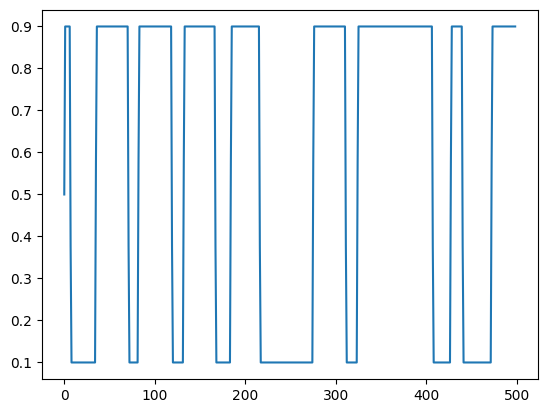

In [ ]:
model1_test = LSTM()
model1_test.load_state_dict(torch.load('MODEL1.pt'))

bat_val = []; bat_test = []
cha_val = []; cha_test = []
dis_val = []; dis_test = []
rev_val = []; rev_test = []

state = env_val.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for k in range(len(env_val.data_imb)-1):
    action, next_history = model1_test.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
    if action==0: actionX=[-100000.0]
    if action==1: actionX=[0.0]
    if action==2: actionX=[100000.0]
    next_state, reward, done, info = env_val.step(actionX)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; revenue = info[3]
    bat_val += [bat]
    cha_val += [cha]
    dis_val += [dis]
    rev_val += [revenue]

state = env_test.reset()
history = (torch.zeros([n_layers, 1, hidden_size], dtype=torch.float), torch.zeros([n_layers, 1, hidden_size], dtype=torch.float))
for l in range(len(env_test.data_imb)-1):
    action, next_history = model1_test.sample_action(torch.tensor(state[-1], dtype=torch.float), history, 0.0)
    if action==0: actionX=[-100000.0]
    if action==1: actionX=[0.0]
    if action==2: actionX=[100000.0]
    next_state, reward, done, info = env_test.step(actionX)

    state = next_state[:]
    history = next_history

    bat = info[0]; cha = info[1]; dis = info[2]; revenue = info[3]
    bat_test += [bat]
    cha_test += [cha]
    dis_test += [dis]
    rev_test += [revenue]

REV_val   = round(max_price*100*np.mean(rev_val),3)
REV_test  = round(max_price*100*np.mean(rev_test),3)
print("REV_val: ${}".format(REV_val).ljust(25), end="")
print("REV_test: ${}".format(REV_test).ljust(25))
print("------------------------------------------------------------------------------------------")

plt.plot(bat_test)